In [2]:
import pandas as pd

def clean(week_nums):
    dfs = []
    for week_num in week_nums:
        url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
        file_url = url.format(week_num)
        names = ['c_a', 'unit', 'scp', 'station', 'linename', 'division', 
                 'date', 'time', 'desc', 'entries', 'exits']
        df = pd.read_csv(file_url, names=names, parse_dates=[['date','time']], 
                         keep_date_col=True, skiprows=1)
        df['date'] = pd.to_datetime(df['date'])
        df['day_of_week'] = df['date_time'].dt.day_name()
        df = df[(~df['c_a'].str.contains('PTH') & 
                 ~df['desc'].str.contains('RECOVR') & 
                 df.time.astype(str).str.contains('00:00'))]
        df = df[['station', 'unit', 'c_a', 'scp', 'date_time', 'date', 'day_of_week', 'time', 
                'desc', 'entries', 'exits']]
        #delete duplicates -> could be done after dataframe creation instead of in this loop
        df.sort_values(['c_a', 'unit', 'scp', 'station', 'date_time'], inplace=True, ascending=False)
        df.drop_duplicates(subset=['c_a', 'unit', 'scp', 'station', 'date_time'], inplace=True)
        dfs.append(df)
        print(week_num)
    return pd.concat(dfs)

week_nums = [200627]

In [3]:
turnstiles_df = clean(week_nums)

200627


In [4]:
turnstiles_df.date


206670   2020-06-26
206669   2020-06-26
206668   2020-06-26
206667   2020-06-26
206666   2020-06-26
            ...    
4        2020-06-20
3        2020-06-20
2        2020-06-20
1        2020-06-20
0        2020-06-20
Name: date, Length: 189525, dtype: datetime64[ns]

In [5]:
turnstiles_block = (turnstiles_df
                        .groupby(["c_a", "unit", "scp", "station", "date_time", "exits"],as_index=False).entries.first())
turnstiles_block[["prev_datetime", "prev_entries", "prev_exits"]] = (turnstiles_block
                                                       .groupby(["c_a", "unit", "scp", "station"])["date_time", "entries", "exits"]
                                                       .apply(lambda grp: grp.shift(1)))
turnstiles_block.dropna(subset=["prev_datetime"], axis=0, inplace=True)
def get_counts_entry(row, max_counter):
    counter = row["entries"] - row["prev_entries"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["entries"], row["prev_entries"])
        counter = min(row["entries"], row["prev_entries"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter
def get_counts_exit(row, max_counter):
    counter = row["exits"] - row["prev_exits"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["exits"], row["prev_exits"])
        counter = min(row["exits"], row["prev_exits"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

<ipython-input-5-7112b57ef14a>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_block[["prev_datetime", "prev_entries", "prev_exits"]] = (turnstiles_block


In [6]:
turnstiles_block['delta_entries'] = turnstiles_block.apply(get_counts_entry, axis=1, max_counter=1e5)

43 8360152.0
9 621129.0
12 2393140.0
56 499510.0
78 920207.0
262144 0.0
654322392 2808057.0
2808205 654322392.0
15 6666024.0
1703967 17387249.0
31 517645.0


In [7]:
turnstiles_block['delta_exits'] = turnstiles_block.apply(get_counts_exit, axis=1, max_counter=15000)
turnstiles_block

22 10927677.0
2 560805.0
1 1578147.0
111 487353.0
65537 83.0
67101704 1833174.0
1833360 67101704.0
2 850518.0
5 3597248.0
12 285863.0


,c_a,unit,scp,station,date_time,exits,entries,prev_datetime,prev_entries,prev_exits,delta_entries,delta_exits
1,A002,R051,02-00-00,59 ST,2020-06-20 04:00:00,2522559,7424220,2020-06-20 00:00:00,7424218.0,2522558.0,2.0,1.0
2,A002,R051,02-00-00,59 ST,2020-06-20 08:00:00,2522572,7424231,2020-06-20 04:00:00,7424220.0,2522559.0,11.0,13.0
3,A002,R051,02-00-00,59 ST,2020-06-20 12:00:00,2522590,7424265,2020-06-20 08:00:00,7424231.0,2522572.0,34.0,18.0
4,A002,R051,02-00-00,59 ST,2020-06-20 16:00:00,2522604,7424340,2020-06-20 12:00:00,7424265.0,2522590.0,75.0,14.0
5,A002,R051,02-00-00,59 ST,2020-06-20 20:00:00,2522612,7424415,2020-06-20 16:00:00,7424340.0,2522604.0,75.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
189520,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-06-26 05:00:00,514,5554,2020-06-26 01:00:00,5554.0,514.0,0.0,0.0
189521,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-06-26 09:00:00,514,5554,2020-06-26 05:00:00,5554.0,514.0,0.0,0.0
189522,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-06-26 13:00:00,514,5554,2020-06-26 09:00:00,5554.0,514.0,0.0,0.0
189523,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-06-26 17:00:00,514,5554,2020-06-26 13:00:00,5554.0,514.0,0.0,0.0


In [8]:
# mf = turnstiles_block.groupby(['unit', 'station', 'date_time',]).agg({'delta_exits': 'sum'}).reset_index()
# mf[:50]

In [9]:



# top10 = (mf.sort_values(by='delta_exits',ascending=False).station.head(10))
# #pd.DataFrame(top10)
# top10

In [25]:
#unit vs Station name
#station complexes vs units vs sationts?

unit_hourly = (turnstiles_block.groupby(['station','unit','date_time'])['delta_exits'].sum().reset_index())

In [26]:
unit_hourly[:50]

,station,unit,date_time,delta_exits
0,1 AV,R248,2020-06-20 04:00:00,79.0
1,1 AV,R248,2020-06-20 08:00:00,359.0
2,1 AV,R248,2020-06-20 12:00:00,643.0
3,1 AV,R248,2020-06-20 16:00:00,797.0
4,1 AV,R248,2020-06-20 20:00:00,675.0
5,1 AV,R248,2020-06-21 00:00:00,390.0
6,1 AV,R248,2020-06-21 04:00:00,60.0
7,1 AV,R248,2020-06-21 08:00:00,257.0
8,1 AV,R248,2020-06-21 12:00:00,491.0
9,1 AV,R248,2020-06-21 16:00:00,687.0


In [51]:
top = unit_hourly.groupby(['station','unit', 'date_time'])['delta_exits'].sum().reset_index()

        

top10 = (top.sort_values(by=['delta_exits'],ascending=False)
        .station.head(100))

In [52]:
top10units = top10.unique()[:10]
top10units

array(['14 ST-UNION SQ', 'FLUSHING-MAIN', '42 ST-PORT AUTH',
       '47-50 STS ROCK', 'JUNCTION BLVD', 'JKSN HT-ROOSVLT',
       'JAMAICA CENTER', '34 ST-HERALD SQ', 'BEDFORD AV', '86 ST'],
      dtype=object)

In [53]:
top5units = top10.unique()[:5]
top5units

array(['14 ST-UNION SQ', 'FLUSHING-MAIN', '42 ST-PORT AUTH',
       '47-50 STS ROCK', 'JUNCTION BLVD'], dtype=object)

In [54]:
top10

1138     14 ST-UNION SQ
1144     14 ST-UNION SQ
1130     14 ST-UNION SQ
1142     14 ST-UNION SQ
11678     FLUSHING-MAIN
              ...      
5816              77 ST
5680        72 ST-2 AVE
1145     14 ST-UNION SQ
5060     59 ST COLUMBUS
5066     59 ST COLUMBUS
Name: station, Length: 100, dtype: object

In [55]:
top.iloc[2133]

station                182-183 STS
unit                          R237
date_time      2020-06-20 16:00:00
delta_exits                    183
Name: 2133, dtype: object

In [56]:
mask = (unit_hourly['unit'] == 'R001')
sample_df = unit_hourly[mask].head(50)

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [58]:
mask = unit_hourly['station'] == '14 ST-UNION SQ'
sample_df = unit_hourly[mask]
sample_df.shape

(41, 4)

NameError: name 'a' is not defined

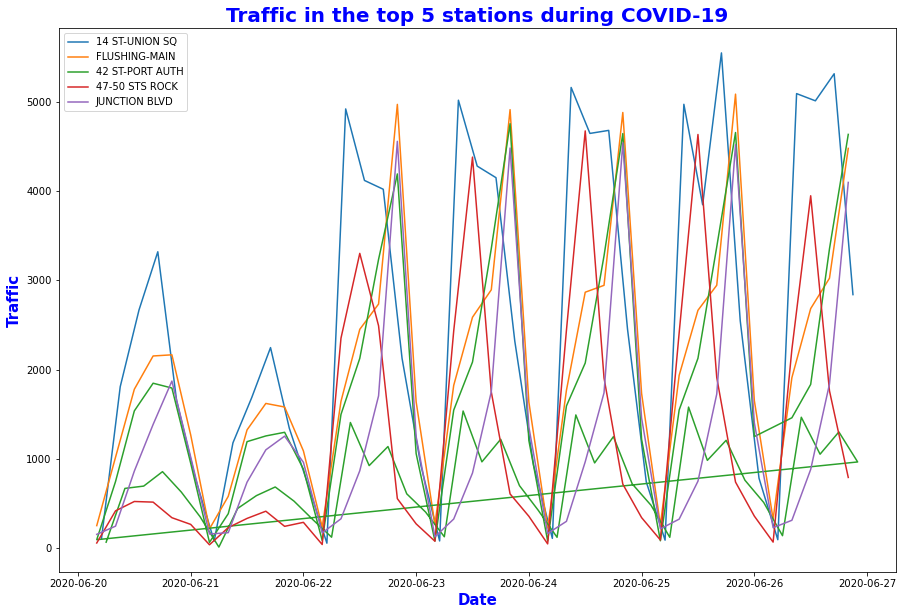

In [59]:
plt.figure(figsize=[15,10])
#plt.plot(sample_df.date_time, sample_df.delta_exits)

for i in top5units:
    mask = (unit_hourly['station'] == i)
    top5_df = unit_hourly[mask]

    plt.plot(top5_df.date_time, top5_df.delta_exits, label = top5_df.station.iloc[0])
plt.legend()

plt.title('Traffic in the top 5 stations during COVID-19', fontsize=20, weight='bold',color='b')
plt.xlabel('Date', fontsize=15, weight='bold',color='b')
plt.ylabel('Traffic', fontsize=15, weight='bold',color='b')
a
plt.savefig('top5 stations traffic.png')

In [20]:
plt.figure(figsize=[15,10])
plt.plot(sample_df.date_time, sample_df.delta_exits)

for i in top10units:
    mask = (unit_hourly['unit'] == i)
    top5_df = unit_hourly[mask].head(50)

    plt.plot(top5_df.date_time, top5_df.delta_exits, label = unit_hourly['unit' ==i]
plt.legend()

SyntaxError: invalid syntax (<ipython-input-20-afb0777968e8>, line 9)